In [1]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.cluster.hierarchy import linkage,leaves_list, dendrogram
from scipy.spatial.distance import pdist, euclidean
from scipy.special import comb

Reading h5 files. As per code on Github

In [2]:
# gives the name of dataset we want as an input
# celltype / celltype_dataset / celltype_dataset_timepoint
def read_file(dataset_name):
    h5_data = h5py.File('./output/condensed_lung_atlas_in_cpm.h5',"r")
    
    df = pd.DataFrame(data=np.array(h5_data[dataset_name]\
    ['gene_expression_average']['block0_values']),\
    index=np.array(h5_data[dataset_name]['gene_expression_average']['axis1'])\
    ,columns=np.array(h5_data[dataset_name]['gene_expression_average']['axis0'])).T

    new_index = []
    for i in df.index:
        new_index.append(i.decode('utf-8'))
    # convert column name from binary to string
    new_column_name = []
    for i in df.columns:
        new_column_name.append(i.decode('utf-8'))
    df.index=new_index
    df.columns=new_column_name
#   d.drop(['CT010467.1'],inplace=True)
    df = df.astype(np.float32)
    
    return df

### Construct a new dataframe for the 3rd heatmap

In [3]:
df = read_file('celltype_dataset_timepoint')

,Adventitial fibroblast_ACZ_P21,Adventitial fibroblast_ACZ_P7,Adventitial fibroblast_Hurskainen2021_P14,Adventitial fibroblast_Hurskainen2021_P3,Adventitial fibroblast_Hurskainen2021_P7,Adventitial fibroblast_TMS_18m,Adventitial fibroblast_TMS_24m,Adventitial fibroblast_TMS_3m,Airway smooth muscle_ACZ_P21,Airway smooth muscle_Hurskainen2021_P14,...,neutrophil_ACZ_E18.5,neutrophil_ACZ_P1,neutrophil_ACZ_P21,neutrophil_ACZ_P7,neutrophil_Hurskainen2021_P14,neutrophil_Hurskainen2021_P3,neutrophil_Hurskainen2021_P7,neutrophil_TMS_18m,neutrophil_TMS_24m,neutrophil_TMS_3m
0610005C13Rik,0.074402,0.0,0.0,2.119141,1.183594,0.000000,0.000000,0.00000,1.085938,2.802734,...,0.309814,0.010681,0.0,0.008118,0.0,0.0,0.0,0.0000,0.0000,0.000000
0610007C21Rik,0.000000,0.0,0.0,0.000000,0.000000,325.000000,375.750000,350.25000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,109.1875,54.6875,31.390625
0610007L01Rik,0.000000,0.0,0.0,0.000000,0.000000,136.000000,129.000000,143.87500,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,79.6250,169.0000,0.000000
0610007N19Rik,0.000000,0.0,0.0,0.000000,0.000000,189.500000,211.750000,198.25000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
0610007P08Rik,0.000000,0.0,0.0,0.000000,0.000000,5.925781,5.886719,51.71875,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s54,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.018829,0.000000,...,0.015053,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s67,0.033966,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.538574,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s68,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.734375,0.0,2.335938,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s8,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000


In [33]:
filtered_df = df.filter(items=['Car4'],axis=0)
filtered_df

,Adventitial fibroblast_ACZ_P21,Adventitial fibroblast_ACZ_P7,Adventitial fibroblast_Hurskainen2021_P14,Adventitial fibroblast_Hurskainen2021_P3,Adventitial fibroblast_Hurskainen2021_P7,Adventitial fibroblast_TMS_18m,Adventitial fibroblast_TMS_24m,Adventitial fibroblast_TMS_3m,Airway smooth muscle_ACZ_P21,Airway smooth muscle_Hurskainen2021_P14,...,neutrophil_ACZ_E18.5,neutrophil_ACZ_P1,neutrophil_ACZ_P21,neutrophil_ACZ_P7,neutrophil_Hurskainen2021_P14,neutrophil_Hurskainen2021_P3,neutrophil_Hurskainen2021_P7,neutrophil_TMS_18m,neutrophil_TMS_24m,neutrophil_TMS_3m
Car4,0.015945,0.0,7.019531,6.179688,9.023438,2.792969,13.703125,4.105469,0.0,14.140625,...,0.0,6.242188,0.056,26.359375,39.53125,25.859375,5.808594,8.78125,0.0,27.359375


In [68]:
# get a list of all the celltypes
all_celltypes = []
all_timepoints = []
all_datasets = []
for column_name in df.columns:
    all_celltypes.append(column_name.split("_")[0])
    all_datasets.append(column_name.split("_")[1])
    all_timepoints.append(column_name.split("_")[2])

# unique
all_celltypes = list(set(all_celltypes))
all_datasets = list(set(all_datasets))
all_timepoints = list(set(all_timepoints))

In [73]:
all_celltypes

['DC I',
 'Pericyte',
 'Early alveolar fibroblast',
 'NK cell',
 'Nonproliferative embryonic EC',
 'Striated muscle',
 'Vascular smooth muscle',
 'Mac IV',
 'Alveolar fibroblast',
 'Early airway smooth muscle',
 'Mac III',
 'Alveolar type I',
 'Adventitial fibroblast',
 'DC II',
 'T cell',
 'Venous EC',
 'Mac V',
 'Airway smooth muscle',
 'neutrophil',
 'DC III',
 'Proliferating fibroblast',
 'Arterial EC II',
 'Proliferating myofibroblast',
 'Lymphatic EC',
 'Mac II',
 'Car4+ capillaries',
 'Early adventitial fibroblast',
 'Early Car4- capillaries',
 'Mac I',
 'IL cell',
 'Fibroblast precursor',
 'Proliferating pericyte',
 'Myofibroblast',
 'Myofibroblast and smooth muscle precursor',
 'basophil',
 'Alveolar type II',
 'Proliferative EC',
 'mast cell',
 'Late Car4- capillaries',
 'B cell',
 'Arterial EC I']

In [75]:
all_timepoints

['E18.5', 'P1', '24m', 'P3', 'P7', 'P21', '3m', '18m', 'P14']

In [76]:
all_datasets

['TMS', 'ACZ', 'Hurskainen2021']

In [69]:
# to construct this for each cell, e.g
# T cell = [
#     TMS->[value1,value2 .....value(length of all timepoints)],
#     ACZ->[value1,value2 .....value(length of all timepoints)],
#     Hurskainen2021->[value1,value2 .....value(length of all timepoints)] 
# ]
bigData = []
for celltype in all_celltypes:
    list_all_dataset = []
    for dataset in all_datasets:
        list_all_times = []
        for timepoint in all_timepoints:
            names = (celltype,dataset,timepoint)
            # check if the combination of celltypes_dataset_timepoint exists
            name = "_".join(names)
            if name not in filtered_df.columns:
                list_all_times.append(0)
                continue
            else:
            # check if the value is None
                has_value = filtered_df[name].values[0]
                if has_value is None:
                    list_all_times.append(0)
                else:
                    list_all_times.append(has_value)
        list_all_dataset.append(list_all_times)
    bigData += list_all_dataset

### Merge all data into one, convert into a big dataframe

In [74]:
#
#           '18m', '24m', '3m', 'E18.5', 'P1', 'P14', 'P21', 'P3', 'P7'
# 'T cell',
# 'B cell',
# 'celltype3',
# 'celltype4',
bigData
# validate: 5.667 for:
# first celltype: DC I
# first dataset:TMS
# third timepiint: 24m


[[0, 0, 5.6679688, 0, 0, 0, 18.171875, 4.5664062, 0],
 [0.0, 0.0, 0, 0, 0.0, 120.1875, 0, 0, 0],
 [0, 0, 0, 0.0, 18.59375, 0, 0, 0, 39.65625],
 [0, 0, 36.1875, 0, 0, 0, 37.03125, 0.0, 0],
 [0.0, 0.0, 0, 0, 3.2226562, 0.0034923553, 0, 0, 0],
 [0, 0, 0, 8.0546875, 17.78125, 0, 0, 0, 7.8867188],
 [0, 0, 0.0, 0, 0, 0, 0, 0, 0],
 [0.0, 0.10986328, 0, 0, 0.3305664, 0.0, 0, 0, 0],
 [0, 0, 0, 42.84375, 4.6914062, 0, 0, 0, 0.0],
 [0, 0, 0.0, 0, 0, 0, 2.9453125, 0.0, 0],
 [0.0, 0.0, 0, 0, 0.0, 12.9140625, 0, 0, 0],
 [0, 0, 0, 29.34375, 0.0, 0, 0, 0, 11.53125],
 [0, 0, 0.0, 0, 0, 0, 0.0, 0, 0],
 [51.65625, 4.8007812, 0, 0, 0.0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 406.25, 0, 0, 0, 0, 0.0, 0],
 [0, 0, 0, 0, 0.0, 0.0, 0, 0, 0],
 [0, 0, 0, 46.9375, 0.0, 0, 0, 0, 0.0],
 [0, 0, 0.0, 0, 0, 0, 0.0, 0.0, 0],
 [0.0, 0.0, 0, 0, 0.0, 4.6679688, 0, 0, 0],
 [0, 0, 0, 0.0, 5.859375, 0, 0, 0, 10.015625],
 [0, 0, 0.0, 0, 0, 0, 176.125, 0.0, 0],
 [0.0, 0.0, 0, 0, 35.96875, 8.203125, 0, 0, 0],
 [0, 0

In [77]:
filtered_df['DC I_TMS_24m'] # validated

Car4    5.667969
Name: DC I_TMS_24m, dtype: float32

In [79]:
all_celltypes_repeated_3 = list(np.repeat(all_celltypes, 3)) # need to repeate for all 3 dataset

In [80]:
big_df = pd.DataFrame(data=bigData,index=all_celltypes_repeated_3,columns=all_timepoints)
big_df

,E18.5,P1,24m,P3,P7,P21,3m,18m,P14
DC I,0.0,0.000000,5.667969,0.000000,0.000000,0.000000,18.171875,4.566406,0.000000
DC I,0.0,0.000000,0.000000,0.000000,0.000000,120.187500,0.000000,0.000000,0.000000
DC I,0.0,0.000000,0.000000,0.000000,18.593750,0.000000,0.000000,0.000000,39.656250
Pericyte,0.0,0.000000,36.187500,0.000000,0.000000,0.000000,37.031250,0.000000,0.000000
Pericyte,0.0,0.000000,0.000000,0.000000,3.222656,0.003492,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
B cell,0.0,0.007492,0.000000,0.000000,0.000000,13.062500,0.000000,0.000000,0.000000
B cell,0.0,0.000000,0.000000,5.609375,8.398438,0.000000,0.000000,0.000000,15.351562
Arterial EC I,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arterial EC I,0.0,0.000000,0.000000,0.000000,15.625000,0.000000,0.000000,0.000000,0.000000


Preprocessing function called by the home page heatmap

In [17]:
def data_preprocessing(gene_names=None):
    data = read_file()
    plot_data_sets = []
    for df in data:
    # current index in the dataframe is writtern as binary string.
    # We need to convert it into normal string
        new_index=[]
        for i in df.index:
            new_index.append(i.decode('utf-8'))
        # Similarly for columns name
        new_columns=[]
        for i in df.columns:
            new_columns.append(i.decode('utf-8'))

        df.index = new_index
        df.columns = new_columns

        all_genes = df.index
        for user_gene in gene_names.split(","):
            if user_gene not in all_genes:
                return None

        if gene_names is None:
            plot_data = df.T
        else:
            a_gene_names = gene_names.split(",")
            plot_df = df.filter(items = a_gene_names,axis=0)
            plot_data = plot_df.T
        plot_data_sets.append(plot_data)
    return plot_data_sets

## The data frame for the home page heatmap

In [4]:
gene_names = "Car4,Vwf,Col1a1,Ptprc,Ms4a1"
df = data_preprocessing(gene_names)[0]
df

,Car4,Vwf,Col1a1,Ptprc,Ms4a1
Adventitial fibroblast,0.124390,0.201660,3426.000000,0.267090,0.053986
Airway smooth muscle,0.186523,0.047241,313.750000,0.138428,0.017746
Alveolar fibroblast,3.177734,0.090088,211.375000,0.257568,0.031952
Alveolar type I,11.031250,0.057281,16.750000,0.208862,0.030045
Alveolar type II,0.500977,0.102722,2.050781,0.265137,0.038635
Arterial EC I,2.658203,521.500000,0.769043,0.231323,0.150024
Arterial EC II,0.058655,553.000000,1.380859,0.143311,0.017487
B cell,1.798828,0.811523,1.472656,268.250000,769.000000
Car4+ capillaries,3092.000000,0.551758,0.651855,0.261475,0.010483
DC I,5.160156,4.960938,0.749023,73.187500,0.042236


The hierarchical conversion from code

In [5]:
dist = pdist(df.values)
Z = linkage(dist,optimal_ordering=True)
new_order = leaves_list(Z)
df = df.iloc[new_order]

In [6]:
df

,Car4,Vwf,Col1a1,Ptprc,Ms4a1
Early adventitial fibroblast,0.574707,0.068665,6952.000000,0.167480,0.008316
Adventitial fibroblast,0.124390,0.201660,3426.000000,0.267090,0.053986
Fibroblast precursor,0.035858,0.036255,2402.000000,0.279053,0.013573
Proliferating fibroblast,0.049774,0.091614,2078.000000,0.348877,0.040802
Early airway smooth muscle,0.061035,0.041901,1381.000000,0.124023,0.023697
Myofibroblast and smooth muscle precursor,0.014977,0.083557,1104.000000,0.078369,0.035492
Arterial EC II,0.058655,553.000000,1.380859,0.143311,0.017487
Arterial EC I,2.658203,521.500000,0.769043,0.231323,0.150024
mast cell,0.000000,0.000000,0.000000,512.500000,0.000000
Mac V,0.124329,5.003906,1.866211,498.000000,0.088745


Let's look at what each step here does.

### Pdist

Let's pick just 4 cell types to simplify things

In [7]:
df_subset = df.iloc[[0, 10, 4, 33]]
df_subset

,Car4,Vwf,Col1a1,Ptprc,Ms4a1
Early adventitial fibroblast,0.574707,0.068665,6952.000000,0.167480,0.008316
neutrophil,2.867188,0.657715,1.108398,493.750000,0.056030
Early airway smooth muscle,0.061035,0.041901,1381.000000,0.124023,0.023697
Vascular smooth muscle,0.397461,3.099609,292.250000,0.171509,0.061951


In [8]:
distance_subset = pdist(df_subset.values)
distance_subset

array([6968.39460457, 5571.00002394, 6659.75069229, 1465.5291507 ,
        573.05778206, 1088.7543474 ])

From documentation, pdist, calculate pairwise distances between observations in n-dimensional space.
In our case, the observations are the cell types (rows).
So when we call pdist, it will calculate the euclidean distance between every combination of 2 cell types.

That's why when we have 4 cell types, it returns array of size 6 as there are 6 possible combinations of cell types (4 choose 2 is 6)

In [9]:
comb(4, 2)

6.0

In [10]:
# Note I have to convert to 32bit as the original values are float 16 bit and it is not enough to represent the distance
euclidean(np.float32(df_subset.iloc[0].values), np.float32(df_subset.iloc[1].values))

6968.39453125

### Linkage
The linkage method performs hierarchical clustering. So from the code, we basically run clustering on the pairwise distance calculation.

From the documentation, we needed N choose 2 sized vector which stores the pairwise distance between the cell type.

What does it return?
A (N-1) by 4 matrix - so 3x4 matrix for us

In [11]:
# Optimal ordering here gives the best result at sacrifice of performance
clust = linkage(distance_subset, optimal_ordering=True)
clust

array([[3.00000000e+00, 1.00000000e+00, 5.73057782e+02, 2.00000000e+00],
       [2.00000000e+00, 4.00000000e+00, 1.08875435e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 5.57100002e+03, 4.00000000e+00]])

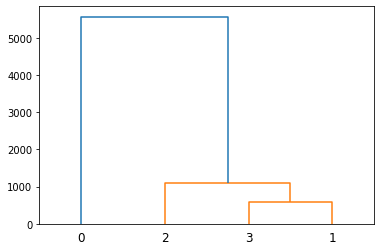

In [12]:
from matplotlib import pyplot as plt
fig = plt.figure()
dn = dendrogram(clust)

So what does the array content mean? A bit complicated.
The 1st array:

1. 1st two elements tell you which cell types form a cluster (1st and 3rd cell type).
2. 3rd element tells you the distance between the (1st and 3rd cell type).
3. 4th element tells you how many cell types in the cluster - we have 2.

2nd array is the same thing, but this time, you have cell type at index 4 which doesn't exist as we only have 4 cell types (0-3). So what is this 4? It can only be the combination of the elements in the first array.

3rd is the same. You don't have cell type 5. So 5th could only be the elements inside the 2nd array. 

The arrays are organised from the lowest part of the hierarchy, all the way to the top.

Say you have result that look like this:
```
[[  1.           2.           1.41421356   2.        ]
 [  0.           3.           5.09901951   2.        ]
 [  4.           5.          10.           4.        ]]
```

and you have 4 cell types. 

Cell type at position 1 and 2 are first clustered together (say cluster 1). 
Then cell type at position 0 and 3 are clustered together (say cluster 2).
 
So now, in total we have 6 elements: 4 cell types and 2 clusters.
So the last entry is the top most hierarchy and combines 4th and 5th element which can only be the 2 clusters.
See the below dendogram.

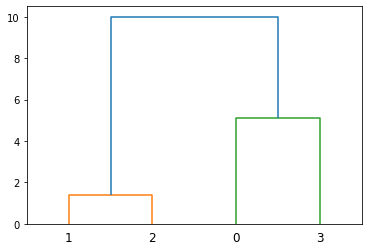

In [13]:
samp_clust = [[1,2,1.41421356,2],
              [0,3,5.09901951,2],
              [4,5,10,4]]
fig = plt.figure()
dn = dendrogram(samp_clust)

### Leaves_list

From the documentation, it retuns a list of leaf nodes. 
Typically after run after running linkage method to get the order of the leaves so we can sort the data.

In [14]:
clust

array([[3.00000000e+00, 1.00000000e+00, 5.73057782e+02, 2.00000000e+00],
       [2.00000000e+00, 4.00000000e+00, 1.08875435e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 5.57100002e+03, 4.00000000e+00]])

In [15]:
leaves_list(clust)

array([0, 2, 3, 1], dtype=int32)

These are the numeric indexes of the cell types. So then you use iloc to reorder the data frame to get positions ordered by hierarchical clustering.

## The data frame for the timepoint heatmap

Prepare the data as per code on Github

In [21]:
df_time_test = read_file('celltype_dataset_timepoint')
df_time_test

,Adventitial fibroblast_ACZ_P21,Adventitial fibroblast_ACZ_P7,Adventitial fibroblast_Hurskainen2021_P14,Adventitial fibroblast_Hurskainen2021_P3,Adventitial fibroblast_Hurskainen2021_P7,Adventitial fibroblast_TMS_18m,Adventitial fibroblast_TMS_24m,Adventitial fibroblast_TMS_3m,Airway smooth muscle_ACZ_P21,Airway smooth muscle_Hurskainen2021_P14,...,neutrophil_ACZ_E18.5,neutrophil_ACZ_P1,neutrophil_ACZ_P21,neutrophil_ACZ_P7,neutrophil_Hurskainen2021_P14,neutrophil_Hurskainen2021_P3,neutrophil_Hurskainen2021_P7,neutrophil_TMS_18m,neutrophil_TMS_24m,neutrophil_TMS_3m
0610005C13Rik,0.074402,0.0,0.0,2.119141,1.183594,0.000000,0.000000,0.00000,1.085938,2.802734,...,0.309814,0.010681,0.0,0.008118,0.0,0.0,0.0,0.0000,0.0000,0.000000
0610007C21Rik,0.000000,0.0,0.0,0.000000,0.000000,325.000000,375.750000,350.25000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,109.1875,54.6875,31.390625
0610007L01Rik,0.000000,0.0,0.0,0.000000,0.000000,136.000000,129.000000,143.87500,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,79.6250,169.0000,0.000000
0610007N19Rik,0.000000,0.0,0.0,0.000000,0.000000,189.500000,211.750000,198.25000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
0610007P08Rik,0.000000,0.0,0.0,0.000000,0.000000,5.925781,5.886719,51.71875,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s54,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.018829,0.000000,...,0.015053,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s67,0.033966,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.538574,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s68,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,1.734375,0.0,2.335938,0.0,0.0,0.0,0.0000,0.0000,0.000000
n-R5s8,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.000000


In [22]:
gene = 'Car4'
df_time_test.filter(regex='^Car4\+ capillaries_ACZ').filter(items=['Car4'],axis=0).T


,Car4
Car4+ capillaries_ACZ_P1,3916.0
Car4+ capillaries_ACZ_P21,7268.0
Car4+ capillaries_ACZ_P7,5444.0


In [18]:
df_time_test.filter(regex='^Car4').filter(items=['Car4'],axis=0).T

,Car4
Car4+ capillaries_ACZ_P1,3916.0
Car4+ capillaries_ACZ_P21,7268.0
Car4+ capillaries_ACZ_P7,5444.0
Car4+ capillaries_Hurskainen2021_P14,430.5
Car4+ capillaries_Hurskainen2021_P3,606.0
Car4+ capillaries_Hurskainen2021_P7,540.5
Car4+ capillaries_TMS_18m,678.0
Car4+ capillaries_TMS_24m,1394.0
Car4+ capillaries_TMS_3m,707.0


In [12]:
print(df_Car4)

                                               Car4
Car4+ capillaries_ACZ_P1                   3916.000
Car4+ capillaries_ACZ_P21                  7268.000
Car4+ capillaries_ACZ_P7                   5444.000
Car4+ capillaries_Hurskainen2021_P14        430.500
Car4+ capillaries_Hurskainen2021_P3         606.000
Car4+ capillaries_Hurskainen2021_P7         540.500
Car4+ capillaries_TMS_18m                   678.000
Car4+ capillaries_TMS_24m                  1394.000
Car4+ capillaries_TMS_3m                    707.000
Early Car4- capillaries_ACZ_E18.5           727.000
Early Car4- capillaries_ACZ_P1              242.875
Early Car4- capillaries_ACZ_P21             310.000
Early Car4- capillaries_ACZ_P7              268.000
Early Car4- capillaries_Hurskainen2021_P3   220.125
Early Car4- capillaries_Hurskainen2021_P7   195.625
Late Car4- capillaries_ACZ_E18.5             47.625
Late Car4- capillaries_ACZ_P1               268.250
Late Car4- capillaries_ACZ_P21              585.500
Late Car4- c

In [20]:
print(df_time_test.filter(items=['Car4'],axis=0).T)

                                                Car4
Adventitial fibroblast_ACZ_P21              0.015945
Adventitial fibroblast_ACZ_P7               0.000000
Adventitial fibroblast_Hurskainen2021_P14   7.019531
Adventitial fibroblast_Hurskainen2021_P3    6.179688
Adventitial fibroblast_Hurskainen2021_P7    9.023438
...                                              ...
neutrophil_Hurskainen2021_P3               25.859375
neutrophil_Hurskainen2021_P7                5.808594
neutrophil_TMS_18m                          8.781250
neutrophil_TMS_24m                          0.000000
neutrophil_TMS_3m                          27.359375

[308 rows x 1 columns]


In [30]:

# select columns by regular expression
data = df_tp.filter(regex='ACZ', axis=1)
timepoint = set(name.split('_')[2] for name in data.columns)

IndexError: list index out of range

Get data for a gene name. 

In [6]:
df_filtered.columns

Index(['Adventitial fibroblast_ACZ_P21', 'Adventitial fibroblast_ACZ_P7',
       'Adventitial fibroblast_Hurskainen2021_P14',
       'Adventitial fibroblast_Hurskainen2021_P3',
       'Adventitial fibroblast_Hurskainen2021_P7',
       'Adventitial fibroblast_TMS_18m', 'Adventitial fibroblast_TMS_24m',
       'Adventitial fibroblast_TMS_3m', 'Airway smooth muscle_ACZ_P21',
       'Airway smooth muscle_Hurskainen2021_P14',
       ...
       'neutrophil_ACZ_E18.5', 'neutrophil_ACZ_P1', 'neutrophil_ACZ_P21',
       'neutrophil_ACZ_P7', 'neutrophil_Hurskainen2021_P14',
       'neutrophil_Hurskainen2021_P3', 'neutrophil_Hurskainen2021_P7',
       'neutrophil_TMS_18m', 'neutrophil_TMS_24m', 'neutrophil_TMS_3m'],
      dtype='object', length=311)

In [35]:
import numpy as np
datasets = set([name.split("_")[1] for name in df_filtered.columns])
dic_per_dataset = {}
data_type = "log10"
plot_type = 'hieracical'

# for each dataset (ACZ,TMS..etc), we construct a cell type x timepoint dataframe
for i in datasets:
    dataset_name = df_filtered.filter(regex=i, axis=1)
    timepoints = set([name.split("_")[2] for name in dataset_name.columns])
    celltypes = set([name.split("_")[0] for name in dataset_name.columns])

    # create a new empty dataframe for each dataset   
    gene_exp_df = pd.DataFrame(np.eye(len(celltypes),len(timepoints)), columns=timepoints, index=celltypes)
    for tp in timepoints:
        for ct in celltypes:
            regex = '_'.join([ct,i,tp])
            gene_expression = dataset_name.filter(regex=regex,axis=1)
            if gene_expression.empty:
                gene_expression = 0
            else:
                gene_exp_df[tp][ct] = gene_expression = gene_expression.iloc[0,0] # same as getting the gene_expression value
    if data_type == "log10":
        gene_exp_df = np.log10(0.1+gene_exp_df)  
    if plot_type == 'hieracical':
        distance = pdist(gene_exp_df.values)
        # print(distance)
        Z = linkage(distance,optimal_ordering=True)
        new_order = leaves_list(Z)
        gene_exp_df = gene_exp_df.iloc[new_order]
    dic_per_dataset[i] = gene_exp_df

dic_per_dataset['TMS']


,18m,3m,24m
Early airway smooth muscle,0.957173,-1.000000,-1.000000
Alveolar type I,-1.000000,0.252957,-1.000000
NK cell,-1.000000,-0.319971,-0.307525
Alveolar type II,-0.709487,-0.515589,-0.843555
Mac IV,-1.000000,-1.000000,-0.768442
DC III,-1.000000,-1.000000,-0.734068
Lymphatic EC,-1.000000,-0.874690,-0.635506
DC II,-1.000000,-1.000000,-0.563103
B cell,-1.000000,-0.705433,-0.677685
neutrophil,-1.000000,-0.680216,-0.741605


In [11]:
df_per_dataset

{'ACZ':         Adventitial fibroblast_ACZ_P21  Adventitial fibroblast_ACZ_P7  \
 Col1a1                         17184.0                         7756.0   
 
         Airway smooth muscle_ACZ_P21  Alveolar fibroblast_ACZ_P21  \
 Col1a1                        1850.0                       1833.0   
 
         Alveolar type II_ACZ_E18.5  Alveolar type II_ACZ_P1  \
 Col1a1                     56.0625                   70.375   
 
         Alveolar type II_ACZ_P21  Alveolar type II_ACZ_P7  \
 Col1a1                       0.0                  196.875   
 
         Alveolar type I_ACZ_E18.5  Alveolar type I_ACZ_P1  ...  \
 Col1a1                   3.230469                  1551.0  ...   
 
         basophil_ACZ_P1  basophil_ACZ_P21  basophil_ACZ_P7  \
 Col1a1              0.0               0.0              0.0   
 
         mast cell_ACZ_E18.5  mast cell_ACZ_P1  mast cell_ACZ_P7  \
 Col1a1                  0.0               0.0               0.0   
 
         neutrophil_ACZ_E18.5  neutrophil_A

We need to get similar type of data frame, replacing the genes by the time-point.

We have 3 different datasets now. I suggest we have 3 different dataframes, one for each data-set.
Each dataframe will have cell type as the rows, and time-points as the columns.